In [24]:
import os
# os.chdir('CLIP-dissect')
!pip install --upgrade pip
!pip install ftfy regex
!pip install diffusers
!pip install accelerate
!pip install pandas
!pip install torch==2.0
!pip install matplotlib
!pip install torchvision==0.15.1
!pip install transformers==4.28.0
!pip install tqdm==4.65.0
!pip install numpy

import clip
import data_utils
import similarity
import utils
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [18]:
from transformers import pipeline
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
generator = torch.Generator(device="cuda").manual_seed(0)
pipe = pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [11]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer1'
d_probe = 'broden' # Change this to imagenet_val
concept_set = 'data/20k.txt' # Change this to 20k

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

In [213]:
concept = 'food'

num_images_per_prompt = 20

new_images = pipe(concept, generator = generator, num_images_per_prompt = num_images_per_prompt, num_inference_steps=15).images

clip_model, clip_preprocess = clip.load(clip_name, device=device)

tmp_class_c = data_utils.get_data('cifar100_train', clip_preprocess)
tmp_class_c.data = np.empty([0,32,32,3], dtype = np.uint8)
tmp_class_c.targets = []
data_c = tmp_class_c

for idx in range (len(new_images)):
    image = new_images[idx]
    image = image.resize([32,32])
    img_array = np.array(image)
    data_c.data = np.append(data_c.data, [img_array], axis = 0)
    data_c.targets.append(-1)


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified


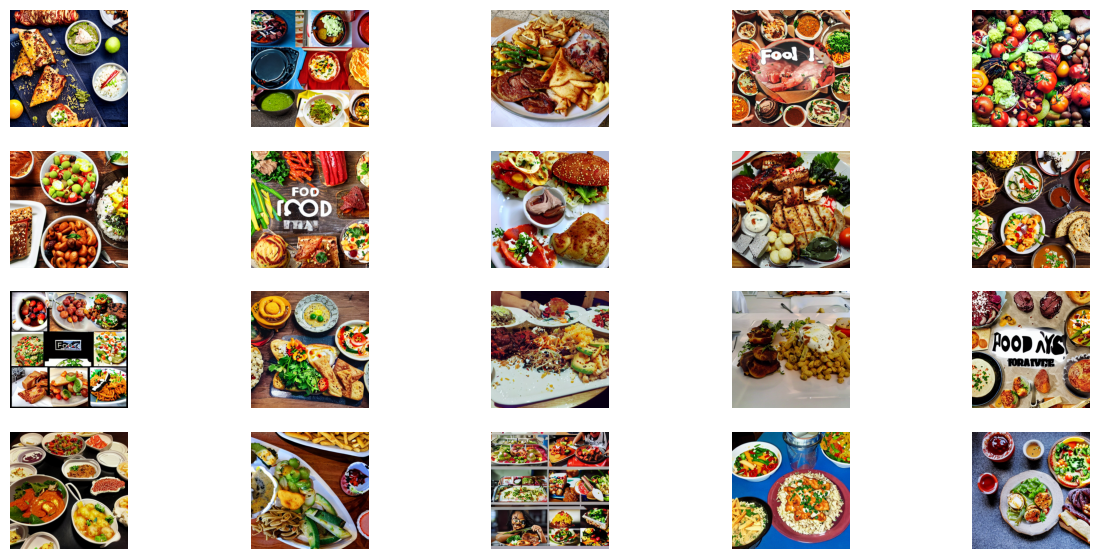

In [214]:
fig = plt.figure(figsize=(15, 7))
for i, im in enumerate(new_images):
    im = im.resize([375,375])
    fig.add_subplot(4, 5, i+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()
    

In [215]:
all_features = []
with torch.no_grad():
    for images, labels in DataLoader(data_c, batch_size, num_workers = 8):
        features = clip_model.encode_image(images.to(device))
        all_features.append(features)

all_features = all_features[0]
all_features /= all_features.norm(dim=-1, keepdim=True)

print(all_features.shape)

inner = (all_features @ all_features.T)

print(inner.shape)
for i in range(len(inner)):
    for j in inner[i]:
        print('{0:.2f}'.format(j.item()), end = ' ')
    print('\n')
        
print('\n')

sim_idx = torch.mean(inner)

print(sim_idx.item())

torch.Size([20, 512])
torch.Size([20, 20])
1.00 0.94 0.93 0.92 0.91 0.93 0.88 0.92 0.93 0.94 0.92 0.93 0.90 0.90 0.91 0.93 0.94 0.82 0.91 0.94 

0.94 1.00 0.89 0.94 0.90 0.94 0.85 0.88 0.90 0.96 0.94 0.91 0.86 0.85 0.87 0.93 0.95 0.84 0.90 0.93 

0.93 0.89 1.00 0.91 0.86 0.92 0.84 0.93 0.95 0.90 0.90 0.93 0.93 0.93 0.86 0.91 0.93 0.79 0.90 0.93 

0.92 0.94 0.91 1.00 0.90 0.94 0.85 0.88 0.92 0.95 0.93 0.90 0.88 0.85 0.88 0.93 0.94 0.83 0.88 0.92 

0.91 0.90 0.86 0.90 1.00 0.88 0.83 0.84 0.87 0.91 0.89 0.85 0.84 0.82 0.88 0.87 0.90 0.88 0.85 0.86 

0.93 0.94 0.92 0.94 0.88 1.00 0.85 0.91 0.93 0.96 0.94 0.94 0.91 0.89 0.86 0.95 0.94 0.83 0.91 0.94 

0.88 0.85 0.84 0.85 0.83 0.85 1.00 0.84 0.84 0.85 0.85 0.85 0.83 0.83 0.90 0.85 0.86 0.77 0.84 0.85 

0.92 0.88 0.93 0.88 0.84 0.91 0.84 1.00 0.91 0.89 0.89 0.93 0.90 0.92 0.85 0.90 0.91 0.78 0.89 0.93 

0.93 0.90 0.95 0.92 0.87 0.93 0.84 0.91 1.00 0.90 0.91 0.92 0.93 0.89 0.86 0.91 0.93 0.82 0.87 0.92 

0.94 0.96 0.90 0.95 0.91 0.96 0.85 0.89

In [218]:
# vague, good
words = {'grass':'good', 'cow':'good', 'dot':'vague', 'h':'vague',
        'birds':'good', 'stuff':'vague', 'thing':'vague', 'that':'vague',
        'regard':'vague', 'z':'vague', 'water':'good', 'play structure':'good',
        'violin':'good', 'green things':'vague', 'book related places':'good',
        'what':'vague','good':'vague'}

results = {}

for i, concept in enumerate(words):
    evaluation = words[concept]

    num_images_per_prompt = 20

    new_images = pipe(concept, generator = generator, num_images_per_prompt = num_images_per_prompt, num_inference_steps=15).images

    clip_model, clip_preprocess = clip.load(clip_name, device=device)

    tmp_class_c = data_utils.get_data('cifar100_train', clip_preprocess)
    tmp_class_c.data = np.empty([0,32,32,3], dtype = np.uint8)
    tmp_class_c.targets = []
    data_c = tmp_class_c

    for idx in range (len(new_images)):
        image = new_images[idx]
        image = image.resize([32,32])
        img_array = np.array(image)
        data_c.data = np.append(data_c.data, [img_array], axis = 0)
        data_c.targets.append(-1)
        
    all_features = []
    with torch.no_grad():
        for images, labels in DataLoader(data_c, batch_size, num_workers = 8):
            features = clip_model.encode_image(images.to(device))
            all_features.append(features)

    all_features = all_features[0]
    all_features /= all_features.norm(dim=-1, keepdim=True)

    inner = (all_features @ all_features.T)

    sim_idx = torch.mean(inner)

    print('{} ({}/{}): {:.2f}'.format(concept, i, len(words), sim_idx.item()))


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
grass (0/17): 0.95


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
cow (1/17): 0.95


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
dot (2/17): 0.80


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
h (3/17): 0.84


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
birds (4/17): 0.87


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
stuff (5/17): 0.85


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
thing (6/17): 0.85


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
that (7/17): 0.81


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
regard (8/17): 0.87


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
z (9/17): 0.81


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
water (10/17): 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
play structure (11/17): 0.95


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
violin (12/17): 0.90


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
green things (13/17): 0.91


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
book related places (14/17): 0.94


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
what (15/17): 0.83


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
good (16/17): 0.83
